In [73]:
import pandas as pd

df = pd.read_csv('/content/log.txt', sep='\s+', header=1, names=['x', 'y', 'z','vx','vy','vz','u','rho'])

x = df['x']
y = df['y']
z = df['z']
vx = df['vx']
vy = df['vy']
vz = df['vz']
densities = df['rho']

print("x coordinates:", x_coords.head())
print("y coordinates:", y_coords.head())
print("z coordinates:", z_coords.head())

x coordinates: 0    12036.317298
1     -600.536457
2    -8268.154431
3     6240.182401
4     5262.934483
Name: x, dtype: float64
y coordinates: 0    1826.116619
1     416.237357
2    2126.610183
3     372.207785
4    -544.652105
Name: y, dtype: float64
z coordinates: 0      499.497255
1    -2012.908433
2    -6624.863432
3    11477.258428
4    12950.094235
Name: z, dtype: float64


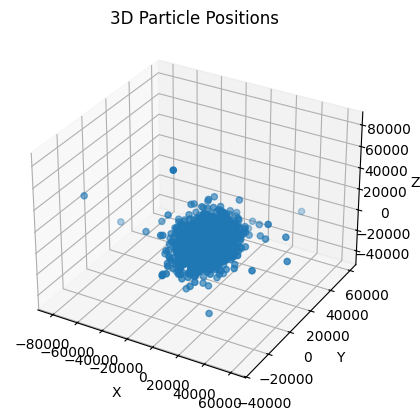

In [74]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Particle Positions')

plt.show()

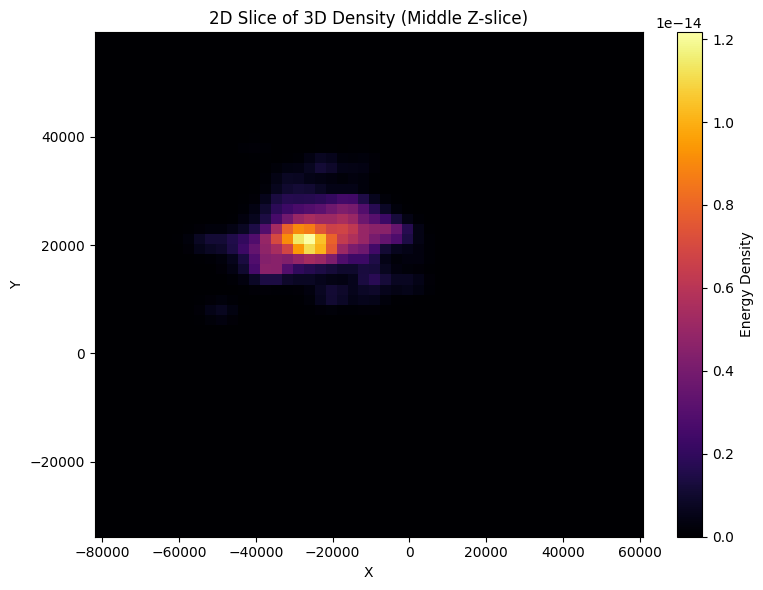

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Extract xyz and energy density (columns 0, 1, 2, and last column)
xyz = df.iloc[:, :3].values
energy_density = df.iloc[:, -1].values

# Use a 3D kernel density estimation
xyz = xyz.T  # transpose for gaussian_kde input (shape should be [n_dim, n_samples])
kde = gaussian_kde(xyz)

# Create a grid of points for evaluation
x_min, y_min, z_min = xyz[0].min(), xyz[1].min(), xyz[2].min()
x_max, y_max, z_max = xyz[0].max(), xyz[1].max(), xyz[2].max()
x_grid, y_grid, z_grid = np.mgrid[x_min:x_max:50j, y_min:y_max:50j, z_min:z_max:50j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])

# Evaluate KDE on the grid
density = kde(positions).reshape(x_grid.shape)

# Visualize a few 2D slices along z-axis
slice_index = density.shape[2] // 2  # middle slice
plt.figure(figsize=(8, 6))
plt.imshow(density[:, :, slice_index], origin='lower', aspect='auto',
           extent=[x_min, x_max, y_min, y_max], cmap='inferno')
plt.colorbar(label='Energy Density')
plt.title("2D Slice of 3D Density (Middle Z-slice)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

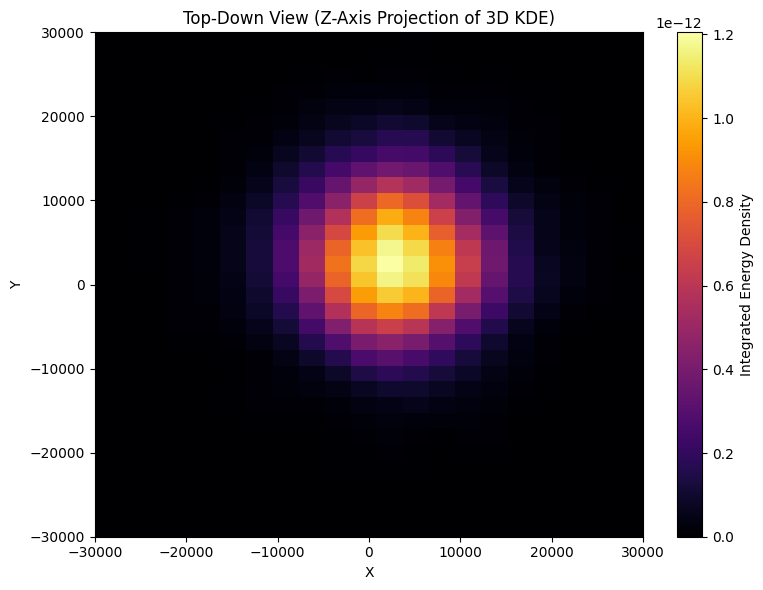

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Extract xyz and energy density (columns 0, 1, 2, and last column)
xyz = df.iloc[:, :3].values
energy_density = df.iloc[:, -1].values

# Transpose for gaussian_kde input (shape should be [n_dim, n_samples])
xyz = xyz.T

# Optional: weight the KDE using energy density
kde = gaussian_kde(xyz, weights=energy_density)

# Create a grid of points for evaluation
x_min, y_min, z_min = xyz[0].min(), xyz[1].min(), xyz[2].min()
x_max, y_max, z_max = xyz[0].max(), xyz[1].max(), xyz[2].max()
x_grid, y_grid, z_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j, z_min:z_max:100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])

# Evaluate KDE on the full 3D grid
#density = kde(positions).reshape(x_grid.shape)

# Collapse density along the Z-axis (axis=2) for a top-down view
top_down_density = density.sum(axis=2)

# Plot the top-down projection
plt.figure(figsize=(8, 6))
plt.imshow(top_down_density.T, origin='lower', aspect='auto',
           extent=[x_min, x_max, y_min, y_max], cmap='inferno')
plt.colorbar(label='Integrated Energy Density')
plt.title("Top-Down View (Z-Axis Projection of 3D KDE)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-30000,30000)
plt.ylim(-30000,30000)
plt.tight_layout()
plt.show()

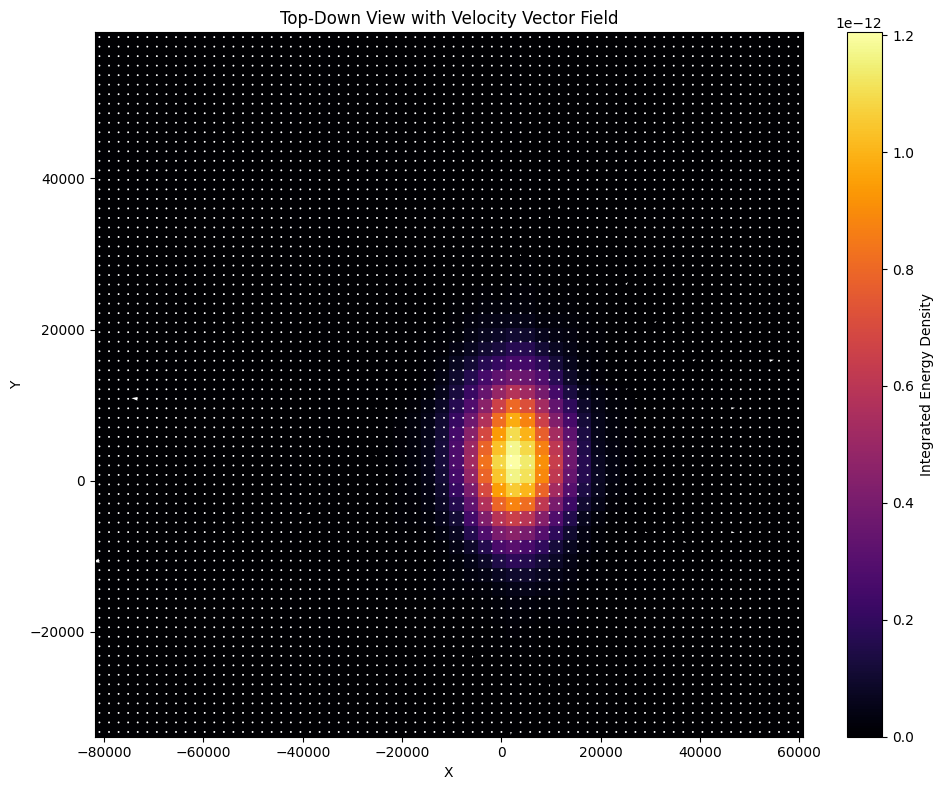

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load your data (assuming the log.txt file has already been read into `df`)
#df = pd.read_csv("log.txt", delim_whitespace=True)

# Extract position and velocity
xyz = df.iloc[:, :3].values.T  # shape: (3, n_samples)
vx, vy = df.iloc[:, 3], df.iloc[:, 4]
energy_density = df.iloc[:, -1]

# KDE with energy density weighting
kde = gaussian_kde(xyz)

# Grid setup
res = 75j
x_min, y_min, z_min = xyz[0].min(), xyz[1].min(), xyz[2].min()
x_max, y_max, z_max = xyz[0].max(), xyz[1].max(), xyz[2].max()

x_grid, y_grid, z_grid = np.mgrid[x_min:x_max:res, y_min:y_max:res, z_min:z_max:res]
positions = np.vstack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])
#density = kde(positions).reshape(x_grid.shape)

# Top-down view: sum over z-axis
top_down_density = density.sum(axis=2)

# Vector field: bin and average vx, vy per XY cell
# We'll use 2D bins matching the KDE resolution
x_bins = np.linspace(x_min, x_max, 75)
y_bins = np.linspace(y_min, y_max, 75)

# Bin indices for each point
x_idx = np.digitize(df['x'], x_bins) - 1
y_idx = np.digitize(df['y'], y_bins) - 1

# Initialize arrays for u (vx), v (vy), and counts
U = np.zeros((74, 74))
V = np.zeros((74, 74))
counts = np.zeros((74, 74))

# Accumulate vx, vy into bins
for xi, yi, vxi, vyi in zip(x_idx, y_idx, vx, vy):
    if 0 <= xi < 74 and 0 <= yi < 74:
        U[xi, yi] += vxi
        V[xi, yi] += vyi
        counts[xi, yi] += 1

# Avoid divide by zero
counts[counts == 0] = 1
U /= counts
V /= counts

max_len = np.amax(np.sqrt(U**2 + V**2))
U /= max_len
V /= max_len

# Prepare meshgrid for quiver
Xc, Yc = np.meshgrid(x_bins[:-1] + np.diff(x_bins) / 2,
                     y_bins[:-1] + np.diff(y_bins) / 2, indexing='ij')

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(top_down_density.T, origin='lower', extent=[x_min, x_max, y_min, y_max],
           cmap='inferno', aspect='auto')
plt.colorbar(label='Integrated Energy Density')
plt.quiver(Xc, Yc, U, V, color='white', scale=100, width=0.003)
plt.title("Top-Down View with Velocity Vector Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


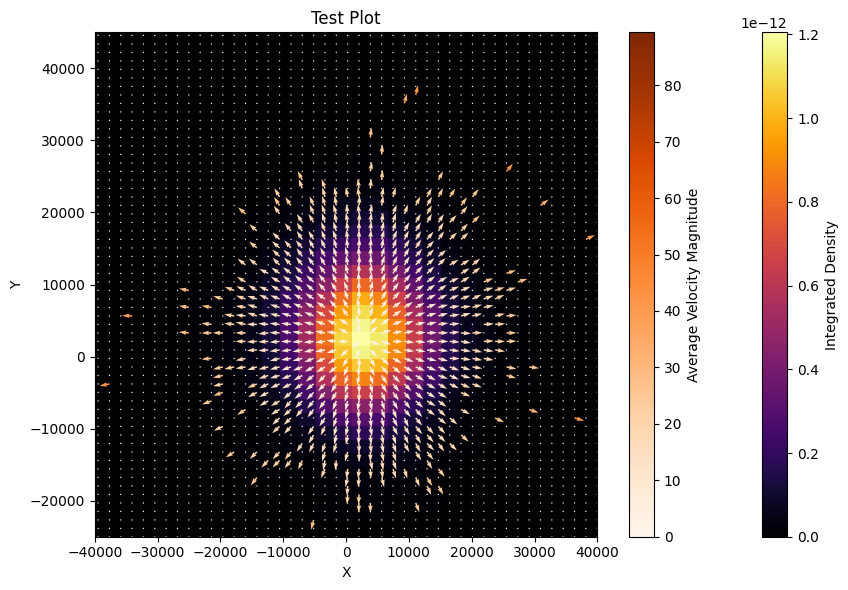

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#Resolution

r = 80
# Load data
df = pd.read_csv('/content/log.txt', sep='\s+', header=1, names=['x', 'y', 'z','vx','vy','vz','u','rho'])

# Extract position and velocity
x, y, z = df['x'], df['y'], df['z']
vx, vy = df['vx'], df['vy']
xyz = np.vstack([x, y, z])

# KDE with energy weighting
kde = gaussian_kde(xyz)

# Grid setup
res = 1j * r
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
z_min, z_max = z.min(), z.max()

x_grid, y_grid, z_grid = np.mgrid[x_min:x_max:res, y_min:y_max:res, z_min:z_max:res]
positions = np.vstack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()])
#density = kde(positions).reshape(x_grid.shape)
top_down_density = density.sum(axis=2)

# Vector field: bin and average vx, vy per XY cell
x_bins = np.linspace(x_min, x_max, r)
y_bins = np.linspace(y_min, y_max, r)
x_idx = np.digitize(x, x_bins) - 1
y_idx = np.digitize(y, y_bins) - 1

U = np.zeros((r-1, r-1))
V = np.zeros((r-1, r-1))
M = np.zeros((r-1, r-1))  # magnitude
counts = np.zeros((r-1, r-1))

for xi, yi, vxi, vyi in zip(x_idx, y_idx, vx, vy):
    if 0 <= xi < r-1 and 0 <= yi < r-1:
        U[xi, yi] += vxi
        V[xi, yi] += vyi
        M[xi, yi] += np.hypot(vxi, vyi)
        counts[xi, yi] += 1

# Avoid divide-by-zero
counts[counts == 0] = 1
U /= counts
V /= counts
M /= counts

# Normalize vectors for direction only
magnitude = np.hypot(U, V)
U_norm = np.divide(U, magnitude, out=np.zeros_like(U), where=magnitude!=0)
V_norm = np.divide(V, magnitude, out=np.zeros_like(V), where=magnitude!=0)

# Meshgrid for quiver
Xc, Yc = np.meshgrid(x_bins[:-1] + np.diff(x_bins) / 2,
                     y_bins[:-1] + np.diff(y_bins) / 2, indexing='ij')

# Plot
plt.figure(figsize=(9, 6))
plt.imshow(top_down_density.T, origin='lower', extent=[x_min, x_max, y_min, y_max],
           cmap='inferno', aspect='auto')
plt.colorbar(label='Integrated Density')

# Use color for magnitude
quiv = plt.quiver(Xc, Yc, U_norm, V_norm, M, cmap='Oranges', scale=50, width=0.003)
plt.colorbar(quiv, label='Average Velocity Magnitude')

plt.title("Test Plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-40000,40000)
plt.ylim(-25000,45000)
plt.tight_layout()
plt.show()
